# Convolutional Neural Network: Visualization

In this notebook, we will visualize what CNN learns. We will cover the filter visualization as well as the regions CNN sees while predicting a class label.

###Filter Visualization

We will load a pretrained CNN network: AlexNet. We will visualize the filter weights. These filter weights gives us the clue as to what the network has learned.

Ref:
1. https://distill.pub/2020/circuits/visualizing-weights/
2. A Survey on Understanding, Visualizations, and Explanation of Deep Neural Networks - Atefeh Shahroudnejad (https://arxiv.org/abs/2102.01792)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

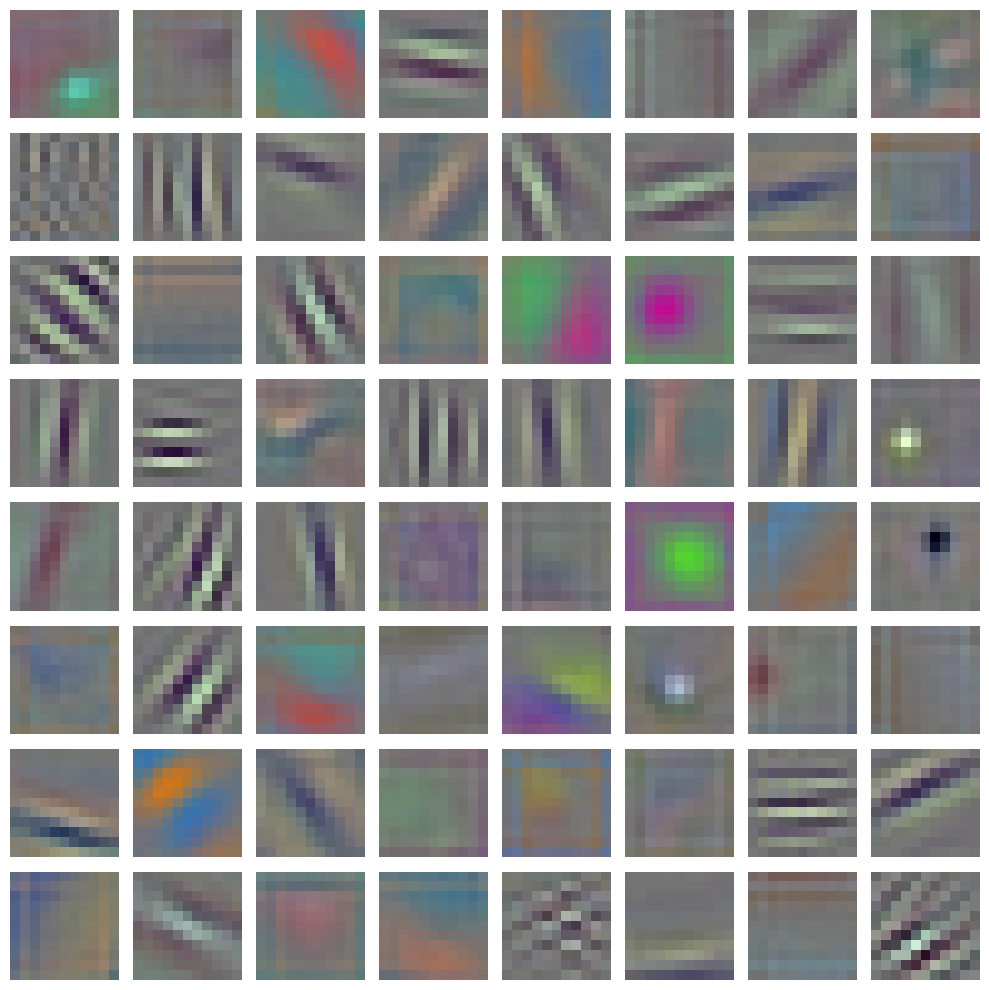

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision.models.alexnet import AlexNet_Weights

# Load pre-trained AlexNet model
alexnet = models.alexnet(weights=AlexNet_Weights.DEFAULT)

print(alexnet)

# Define layer number
layer_num = 0

# Get the weights of the convolutional layers
if isinstance(alexnet.features[layer_num], nn.Conv2d):
  conv_weights = alexnet.features[layer_num].weight.data

  # Normalize the weights to [0, 1] range
  conv_weights_norm = (conv_weights - conv_weights.min()) / (conv_weights.max() - conv_weights.min())

  # Plot the weights
  fig, axes = plt.subplots(8, 8, figsize=(10, 10))
  for i, ax in enumerate(axes.flat):
      # Get the weight tensor for the i-th filter
      weight = conv_weights_norm[i].permute(1, 2, 0)
      # plot only single channel if number of channels is greater than 3
      nb_channels = weight.shape[2]
      if nb_channels > 3:
        weight = weight[:,:,0]
      ax.imshow(weight)
      ax.axis('off')

else:
  print("Can only visualize layers which are convolutional")

plt.tight_layout()
plt.show()


###Class Activation Maps

Project Page: http://cnnlocalization.csail.mit.edu/

Class activation maps are a simple technique to get the discriminative image regions used by a CNN to identify a specific class in the image. In other words, a class activation map (CAM) lets us see which regions in the image were relevant to this class.

To be able to create a CAM, the network architecture is restricted to have a global average pooling layer after the final convolutional layer, and then a linear (dense) layer. Unfortunately this means we can't apply this technique on existing networks that don't have this structure. What we can do is modify existing networks and fine tune them to get this.

The network architecture is shown below:
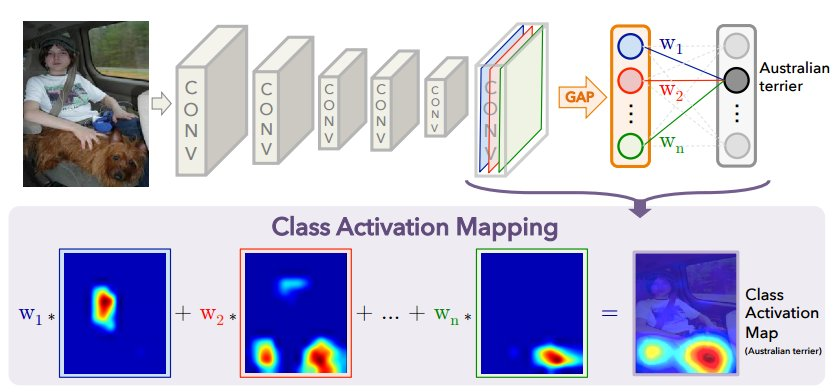

We will now see how CAM works on an example image. We will be using ResNet 34 model and modifying it so that it adapts to CAM framework.

In [36]:
import torch
import torchvision
import PIL
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet34_Weights

model = models.resnet34(weights=ResNet34_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Change the last layer of the model to use Global Average Pooling

In [26]:
def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    # We remove those 3 layers...
    # x = self.avgpool(x)
    # x = torch.flatten(x, 1)
    # x = self.fc(x)

    # ... and we add this layer:
    x = self.conv1x1(x)

    return x

model.forward = forward.__get__(model, torchvision.models.ResNet) # monkey-patching
model.conv1x1 = torch.nn.Conv2d(512, 1000, kernel_size=1)
model.conv1x1.weight.data = model.fc.weight.data[..., None, None]
model.conv1x1.bias.data   = model.fc.bias.data

Test your model after making architectural changes

In [27]:
print("224x224 --->", model.forward(torch.randn(1, 3, 224, 224)).shape )
print("512x512 --->", model.forward(torch.randn(1, 3, 512, 512)).shape )
print("1024x1024 ->", model.forward(torch.randn(1, 3, 1024, 1024)).shape )
print("2048x2048 ->", model.forward(torch.randn(1, 3, 2048, 2048)).shape )

224x224 ---> torch.Size([1, 1000, 7, 7])
512x512 ---> torch.Size([1, 1000, 16, 16])
1024x1024 -> torch.Size([1, 1000, 32, 32])
2048x2048 -> torch.Size([1, 1000, 64, 64])


Download a sample image

In [29]:
!pip -q install gdown
!gdown https://drive.google.com/uc?id=1UZvYpwKrGsXN4LX3LD9gRjYKnEXN-g4p

Downloading...
From: https://drive.google.com/uc?id=1UZvYpwKrGsXN4LX3LD9gRjYKnEXN-g4p
To: /content/dogs.png
100% 230k/230k [00:00<00:00, 24.6MB/s]


Display the image

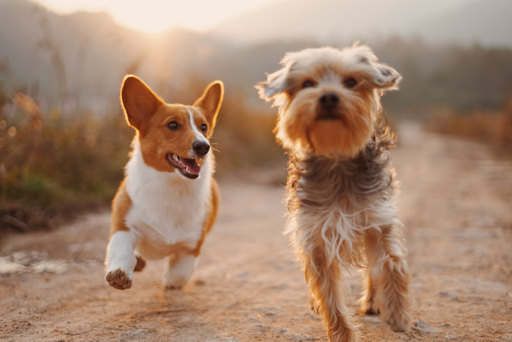

In [31]:
image = PIL.Image.open("/content/dogs.png")
image.thumbnail((512, 512), PIL.Image.LANCZOS)
image

Define transforms for the image

In [32]:
imagenet_mean = torch.tensor([0.485, 0.456, 0.406])
imagenet_std = torch.tensor([0.229, 0.224, 0.225])

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(imagenet_mean, imagenet_std),
])

Generate and plot the CAM

In [33]:
def generate_attention(path, class_indexes, size=(224, 224)):

    ################################ Open and preprocess image
    image = PIL.Image.open(path)
    image.thumbnail(size, PIL.Image.LANCZOS)

    print("Image shape:", image.size)
    tensor = transform(image)[None]

    ################################ Run image through model
    with torch.no_grad():
        logits = model(tensor)[0]
    probs = torch.softmax(logits, dim=0)
    attention_map = probs[class_indexes].sum(dim=0)

    plt.figure(figsize=(16, 8))
    ax = plt.subplot(1, 3, 1)
    ax.axis("off")
    plt.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.axis("off")
    plt.imshow(attention_map)

    ax = plt.subplot(1, 3, 3)
    ax.axis("off")
    ax.imshow(image)
    ax.imshow(attention_map, alpha=0.6, interpolation="bilinear", cmap="magma",
              extent=(0,image.size[0],image.size[1],0))


###See activation for "Yorkshire terrier" (Class index = 187)

Image shape: (224, 150)


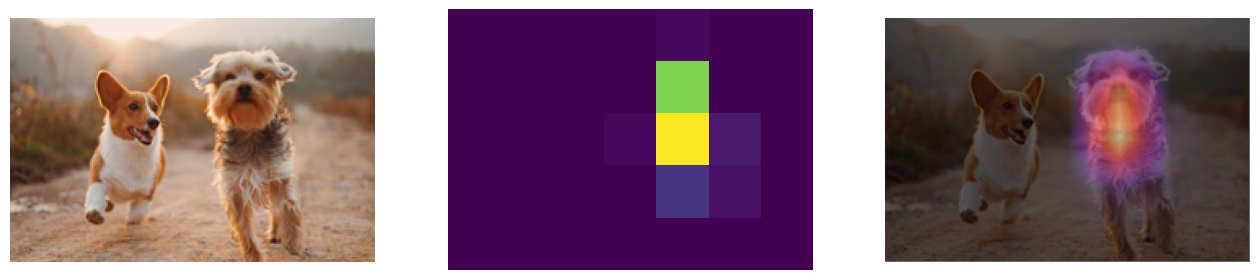

In [34]:
generate_attention("/content/dogs.png", class_indexes=[187])

###See activation for "Corgi" (Class indexes = 263 & 264)
    263: 'Pembroke, Pembroke Welsh corgi',
    264: 'Cardigan, Cardigan Welsh corgi',


Image shape: (224, 150)


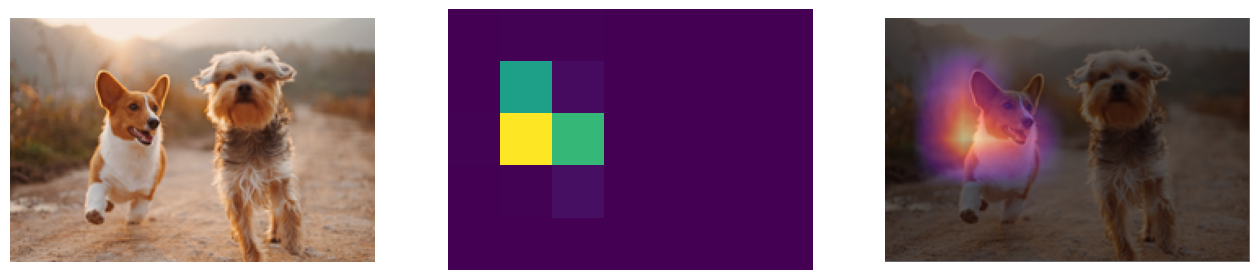

In [35]:
generate_attention("/content/dogs.png", class_indexes=[263,264])

# Where to go from here?

CAM relies on global average pooling, which limits its applicability across various types of models. [Gradient-weighted Class Activation Maps (GradCAM)](https://arxiv.org/abs/1610.02391) and its variants addresses these limitations by incorporating gradient information from upstream layers.

You can refer to the following library that has implementation of several variants of GradCAM: https://github.com/jacobgil/pytorch-grad-cam

